### Spatial Autocorrelation Example

In this example, I will demonstrate how to conduct spatial autocorrelation analysis in python using an example of Georgia's county-level census data.

Specifically, we are mapping the county-level % of people with Bachelor's degree or higher, and conducting global/local moran analysis. Finally, we are able to identify cold spots and hotspots and help us to understand the education inequality in GA.


Load packages

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

import libpysal as ps 
from libpysal.weights.contiguity import Queen,Rook
from libpysal import examples

#!pip install splot #Install once
import splot

Load Georgia dataset from pysal

In [2]:
georgia_shp = gpd.read_file(ps.examples.get_path('G_utm.shp'))

First, again check the data we loaded.

In [3]:
georgia_shp.head()

,AREA,PERIMETER,G_UTM_,G_UTM_ID,Latitude,Longitud,TotPop90,PctRural,PctBach,PctEld,PctFB,PctPov,PctBlack,X,Y,AreaKey,geometry
0,1.331370e+09,207205.0,132,133,31.75339,-82.28558,15744,75.6,8.2,11.43,0.64,19.9,20.76,941396.6,3521764,13001,"POLYGON ((931869.062 3545540.500, 934111.625 3..."
1,8.929300e+08,154640.0,157,158,31.29486,-82.87474,6213,100.0,6.4,11.77,1.58,26.0,26.86,895553.0,3471916,13003,"POLYGON ((867016.312 3482416.000, 884309.375 3..."
2,7.434020e+08,130431.0,148,146,31.55678,-82.45115,9566,61.7,6.6,11.11,0.27,24.1,15.42,930946.4,3502787,13005,"POLYGON ((914656.875 3512190.000, 924718.375 3..."
3,9.053950e+08,185737.0,158,155,31.33084,-84.45401,3615,100.0,9.4,13.17,0.11,24.8,51.67,745398.6,3474765,13007,"POLYGON ((744258.625 3480598.500, 765025.062 3..."
4,6.941830e+08,151347.0,76,79,33.07193,-83.25085,39530,42.7,13.3,8.64,1.43,17.5,42.39,849431.3,3665553,13009,"POLYGON ((832974.188 3677273.500, 834048.688 3..."


The data contains a set of socio-demographic variables. One of them is "PctBach", which is the percentage of population with Bachelor's degree or higher. 

Let's make a map this variable. Clearly, we can see that the % Bach is high around Atlanta and Athens.

Text(0.5, 1.0, 'PctBach')

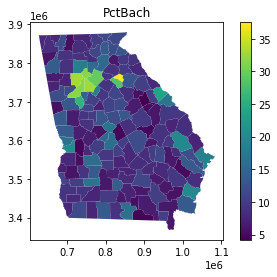

In [4]:
georgia_shp.plot(column="PctBach",legend=True)
plt.title("PctBach")

A map of Georgia for reference 
(source:https://www.enchantedlearning.com/usa/states/georgia/map.GIF)


<img src=https://www.enchantedlearning.com/usa/states/georgia/map.GIF width="200" align="left">

Specify a weight matrix

In [5]:
bach = georgia_shp['PctBach'].values #Get the data we are interested.

w = Queen.from_dataframe(georgia_shp) #Generate W matrix using Queen contiguity

w.transform = 'r' #Row-standardization of the weight matrix

First, let's do a global Moran's I

In [6]:
from esda.moran import Moran

ga_global_moran = Moran(bach, w, permutations = 199) #199 permutations
ga_global_moran.I

0.24861057366498737

This is indicating a statistically significant clustering in the Pct Bach data.


In [7]:
ga_global_moran.p_sim # P value based on permutation tests

0.005

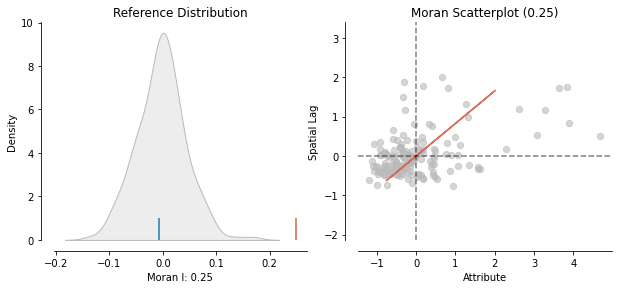

In [8]:
from splot.esda import plot_moran
plot_moran(ga_global_moran, zstandard=True, figsize=(10,4))
plt.show()

Generate a better Moran Scatterplot with significance of the local moran's Is. 

Color code each county with the quadrant it falls into.
- Red: HH
- Light Blue: LH
- Yellow: HL
- Blue: LL

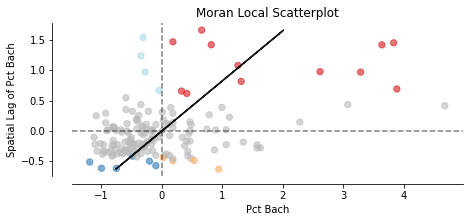

In [9]:
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local
# calculate Moran_Local and plot
ga_moran_loc = Moran_Local(bach, w,permutations=199) #199 permutations for the sig test
fig, ax = moran_scatterplot(ga_moran_loc, p=0.05)
ax.set_xlabel('Pct Bach')
ax.set_ylabel('Spatial Lag of Pct Bach')
plt.show()

Create a hot-spot and cold-spot map. 
- HH: High % Bach county surrounded by High % Bach county
- LL: Low-Low
- LH: Low-High
- HL: High-Low
- NS: Non-significant (p>0.05)

(<Figure size 432x432 with 1 Axes>, <AxesSubplot:>)

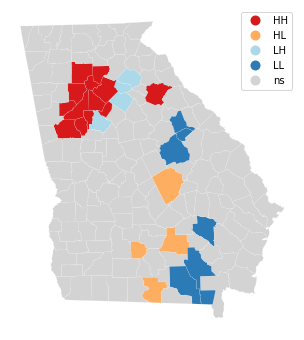

In [10]:
from splot.esda import lisa_cluster
lisa_cluster(moran_loc=ga_moran_loc, gdf=georgia_shp, p = 0.05, figsize = (6,6))